# Generating catalog of sources

This notebook is example of how to generate a catdata object, which a catalog of source with its measurements and metadata.
In order to generate the catalog, we need fitsfiles and the source position (ra, dec) for which the flux needs to be extracted.

In this notebook we will generated the source catalog of Fornax A using images generated from a single day of IDR2.1 HERA data.

In [1]:
%matplotlib notebook
from beam_solver import catdata as cd
from beam_solver import fits_utils as ft
from beam_solver import beam_utils as bt
from beam_solver.data import DATA_PATH
import numpy as np
import glob
import pylab
import os

In [2]:
# path where the fitsfiles are stored
filepath = '/Users/Ridhima/Documents/ucb_projects/beam_characterization/new_fitsfiles'

In [3]:
# getting fitsfiles from the directory
fitsfiles = glob.glob(filepath  + '/2458115*.xx.fits')
fitsfiles.sort()

Adding julian dates as one of the keywords of the header. The julian date is required to calcuale horizontal coordinates (az-alt).

In [4]:
for fn in fitsfiles:
    fnsplit = fn.split('/')[-1].split('.')
    jd = fnsplit[0] + '.' + fnsplit[1]
    jd = float(jd) + 5/24./60.
    ft.add_keyword(fn, 'JD', jd, fn, overwrite=True)

In [5]:
ras = [74.03785836567484]
decs = [-30.08651872619927]

In [6]:
catd = cd.catData()

In [7]:
catd.gen_catalog(ras, decs, fitsfiles_xx=fitsfiles)

/Users/Ridhima/software/anaconda2/lib/python2.7/site-packages/beam_solver-0.1.0-py2.7.egg/beam_solver/extract.py:57: Warning: WARNING: Right ascension or declination outside image field, therefore values are set to nan
  warnings.warn('WARNING: Right ascension or declination outside image field, therefore values are set to nan', Warning)


The data array is of shape (npols, nsources, nfits).

In [8]:
catd.data_array.shape

(1, 1, 55)

<IPython.core.display.Javascript object>


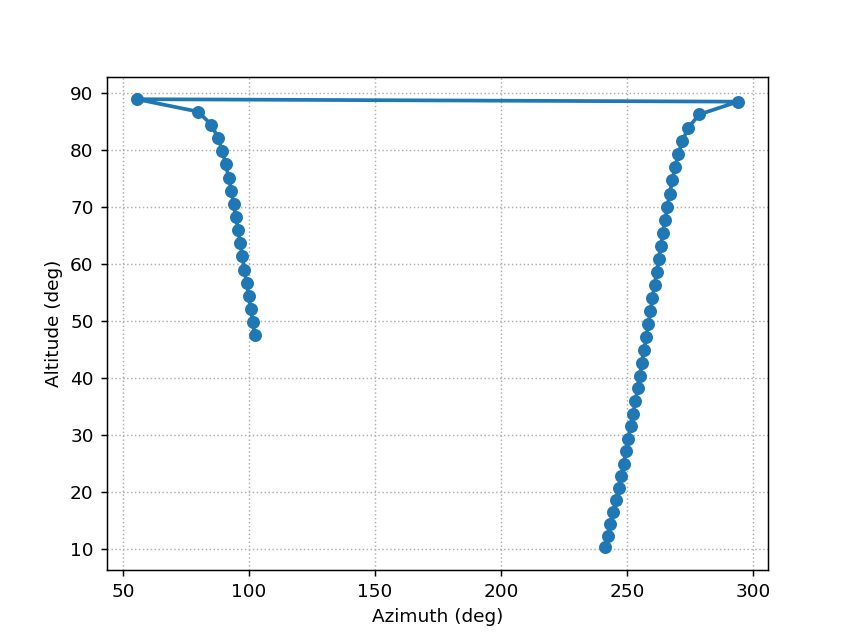

In [9]:
fig = pylab.figure()
pylab.plot(catd.azalt_array[0, 0, :] * 180/np.pi, catd.azalt_array[1, 0, :] * 180/np.pi, 'o-', linewidth=2)
pylab.xlabel('Azimuth (deg)')
pylab.ylabel('Altitude (deg)')
pylab.grid(ls='dotted')

<IPython.core.display.Javascript object>


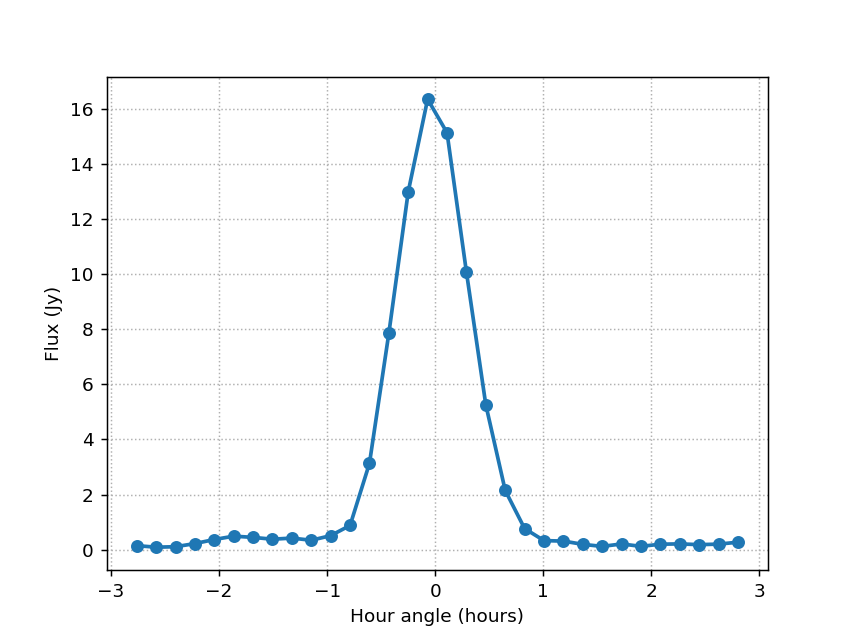

Text(0,0.5,'Flux (Jy)')

In [10]:
fig = pylab.figure()
pylab.plot(catd.ha_array[0, :] * 12/np.pi, catd.data_array[0,0,:], 'o-', linewidth=2)
pylab.grid(ls='dotted')
pylab.xlabel('Hour angle (hours)')
pylab.ylabel('Flux (Jy)')

We can also return the data in the form of dictionary.

In [11]:
srcdict = catd.gen_catalog(ras, decs, fitsfiles, return_data=True)

In [12]:
srcdict.keys()

[(74.04, -30.09)]

## Calculating catalog flux values using measurements from different fits files 

The catalog flux is calculated using

\begin{equation}
 \tilde{S} = \frac{S(t)B(t)}{B(t)^2}
\end{equation}

where $S(t)$ is the flux measurement obtained from each snapshot or time.

In [13]:
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam = bt.get_fitsbeam(beamfits, 151e6)
catalog_flux_xx = catd.calc_catalog_flux(beam, 'xx')
print "Catalog Flux: ", catalog_flux_xx

Catalog Flux:  [16.17166369]


Casting complex values to real discards the imaginary part


## Storing/ Reading source catalog to/from disk 

The data and metadata of the catalog can be stored on disk as an h5py file.

In [14]:
catd.write_hdf5('srcd.h5', clobber=True)

In [16]:
catd_r = cd.catData()
catd.read_hdf5('srcd.h5')

## Interpolating the data points

We can also interpolate the catalog using any desired resolution in hour angle. It uses scipy.interp1d to interpolate the data points or measurement. The default interpolatation method is cubic and you can specify the interpolation according to your requirements.

In [17]:
# interpolating using a resolution of 0.01 radians in hour angle
catd.interpolate_catalog(dha=0.01)

<IPython.core.display.Javascript object>


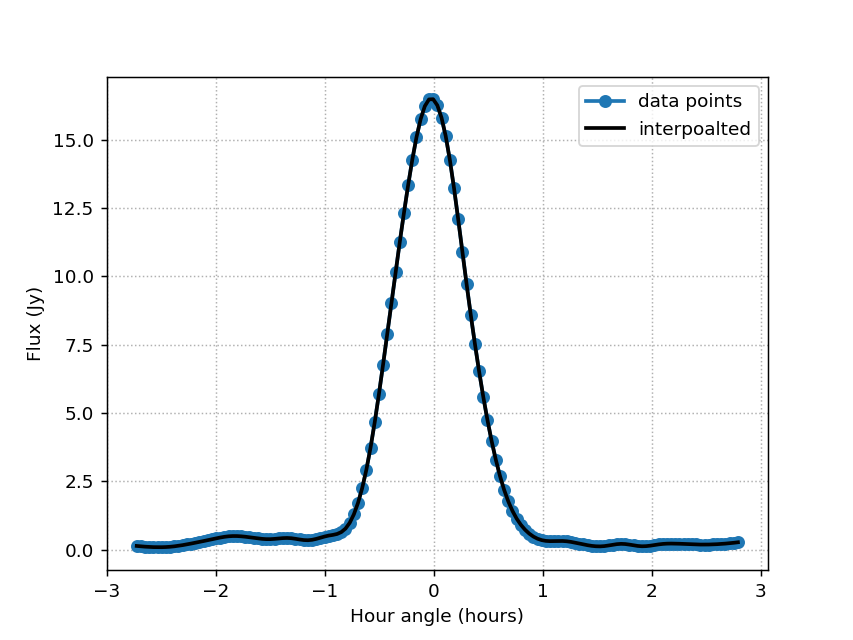

In [20]:
fig = pylab.figure()
pylab.plot(catd.ha_array[0, :] * 12/np.pi, catd.data_array[0,0,:], 'o-', linewidth=2, label='data points')
pylab.plot(catd.ha_array[0, :] * 12/np.pi, catd.data_array[0,0,:], 'k-', linewidth=2, label='interpoalted')
pylab.grid(ls='dotted')
pylab.xlabel('Hour angle (hours)')
pylab.ylabel('Flux (Jy)')
pylab.legend()